# Dogs vs Cats Binary Classifier

The folling is a solution to the dogs vs cats kaggle:

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

Data is expected to be in the following structure:

- data/train/dogs/dog.*.jpg

- data/train/cats/cat.*.jpg

- data/valid/dogs/dog.*.jpg

- data/valid/cats/cat.*.jpg

Download the data from kaggle and then put the data in the above format:

kg download

This solution starts with the VGG16 solution, and it is then fine tuned for the dogs vs cats dataset.

See: https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3

In [27]:
%matplotlib inline
import os

In [28]:
path = 'data'
batch_path = os.path.join(path, 'train')
valid_batch_path = os.path.join(path, 'valid')
print(batch_path, valid_batch_path)

data/train data/valid


In [29]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

In [34]:
import utils; reload(utils)
from utils import plots

In [44]:
import vgg16; reload(vgg16)
from vgg16 import Vgg16
model_file = 'dogsandcats_fit_model.h5'

In [45]:
vgg = Vgg16(model_file=model_file)

Loading weights from /home/ubuntu/.keras/models/vgg16.h5


In [46]:
batch_size = 128
batches = vgg.get_batches(batch_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_batch_path, batch_size=batch_size*2)
vgg.finetune(batches)

Found 25000 images belonging to 2 classes.
Found 2 images belonging to 2 classes.


This is where we fit the dogs and cats to the existing model.  This takes a while even on a GPU.

In [51]:
vgg.fit(batches, val_batches, nb_epoch=1)
vgg.save()

Epoch 1/1
25000/25000 [==============================] - 606s - loss: 0.0872 - acc: 0.9774 - val_loss: 1.1921e-07 - val_acc: 1.0000

Test a batch and see how it does

Found 25000 images belonging to 2 classes.


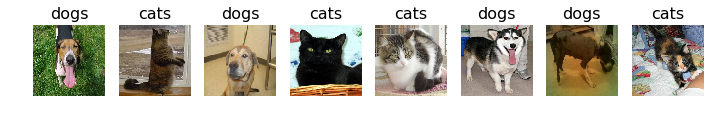

In [52]:
b4 = vgg.get_batches(batch_path, batch_size=8)
imgs,labels = next(b4)
predictions = vgg.predict(imgs, True)
predicted_labels = predictions[2]
plots(imgs, titles=predicted_labels)

Now lets test our model on some data from the test set.  Our model seems to do ok.

In [53]:
from keras.preprocessing import image
import keras.backend as K
import glob

def predict(img_path, target_size, color_mode='rgb'):
    dim_ordering = K.image_dim_ordering()
    if color_mode == 'rgb':
        if dim_ordering == 'tf':
            image_shape = target_size + (3,)
        else:
            image_shape = (3,) + target_size
    else:
        if dim_ordering == 'tf':
            image_shape = target_size + (1,)
        else:
            image_shape = (1,) + target_size
    
    full_images = []
    for path in glob.glob(img_path):
        img = image.load_img(path, target_size=target_size)
        full_images.append(img)

    current_batch_size = len(full_images)
    batch_x = np.zeros((current_batch_size,) + image_shape, dtype=K.floatx())
    for i in range(0, current_batch_size):
        x = image.img_to_array(full_images[i])
        batch_x[i] = x        
   
    all_preds = vgg.model.predict(batch_x)
    idxs = np.argmax(all_preds, axis=1)
    preds = [all_preds[i, idxs[i]] for i in range(len(idxs))]
    classes = [vgg.classes[idx] for idx in idxs]
    return np.array(preds), idxs, classes, full_images



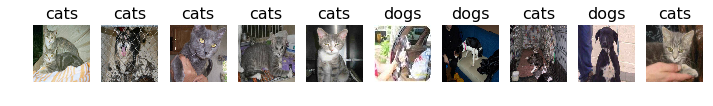

In [54]:
out = predict(os.path.join(path, "test/1021?.jpg"), target_size=(224, 224))
plots(out[3], titles=out[2])

In [55]:
vgg.classes

['cats', 'dogs']

How lets iterate over the test set, and output the solution in the appropriate format for this competition. (CSV)

In [56]:
target_size=(224, 224)
image_shape = (3,) + target_size

def create_sub(path, out_filename, limit=12500):
    fp = open(out_filename, "wb")
    fp.write("id,label\n")    
    for i in range(0,limit):
        current_batch_size = 1
        sample_id = i+1
        filename = os.path.join(path, "%d.jpg" % sample_id)
        batch_x = np.zeros((current_batch_size,) + image_shape, dtype=K.floatx())
        img = image.load_img(filename, target_size=target_size)
        batch_x[0] = image.img_to_array(img)
        all_preds = vgg.model.predict(batch_x)
        idxs = np.argmax(all_preds, axis=1)
        preds = [all_preds[i, idxs[i]] for i in range(len(idxs))]
        cls = [vgg.classes[idx] for idx in idxs]
        name = sample_id
        value = idxs[0]
        fp.write("%d,%d\n" % (name, value))
        fp.flush()
    fp.close()

In [57]:
create_sub(os.path.join(path, "test"), "out.csv")